In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import tqdm
import numpy as np
import espressomd.observables
import espressomd.accumulators

import espressomd.lb
import espressomd.swimmer_helpers

espressomd.assert_features(
    ["ENGINE", "ROTATION", "MASS", "ROTATIONAL_INERTIA", "WALBERLA", "VIRTUAL_SITES_RELATIVE"])


In [2]:
def clear_system(system):
    system.part.clear()
    system.thermostat.turn_off()
    system.constraints.clear()
    system.auto_update_accumulators.clear()
    system.time = 0.

In [3]:
HYDRO_PARAMS = {'box_l': 3*[35],
                'time_step': 0.01,
                'skin': 1,
                'agrid': 1,
                'dens': 0.1,
                'visc': 5,
                'gamma': 2,
                'mass': 1,
                'dipole_length': 1,
                'f_swim': 0.01,
                'dipole_particle_type': 1
                }

HYDRO_N_STEPS = 60
HYDRO_nn_STEPS = 10

system = espressomd.System(box_l=HYDRO_PARAMS['box_l'])
system.box_l = HYDRO_PARAMS['box_l']
system.cell_system.skin = HYDRO_PARAMS['skin']
system.time_step = HYDRO_PARAMS['time_step']
system.min_global_cut = HYDRO_PARAMS['dipole_length']

In [10]:

box_l = np.array(HYDRO_PARAMS['box_l'])
#pos = box_l/4.
#pos[2] = -15.

#box_l = np.array(HYDRO_PARAMS['box_l'])
pos = np.zeros((2, 3))
pos[:,:] = box_l/2.
pos[:,2] = -15.
pos[0,0] = pos[0,1]=10.
pos[1,1] = pos[1,0]=25.


In [11]:
print(pos)

[[ 10.  10. -15.]
 [ 25.  25. -15.]]


In [12]:
# SOLUTION CELL
lbf = espressomd.lb.LBFluidWalberla(agrid=HYDRO_PARAMS['agrid'],
                                    density=HYDRO_PARAMS['dens'],
                                    kinematic_viscosity=HYDRO_PARAMS['visc'],
                                    tau=HYDRO_PARAMS['time_step'])
system.lb = lbf
system.thermostat.set_lb(LB_fluid=lbf, gamma=HYDRO_PARAMS['gamma'], seed=42)

In [23]:
# SOLUTION CELL
director = np.array([0,0,1])
particle = system.part.add(
    pos=pos, 
    director=[director]*2,
    mass=[HYDRO_PARAMS['mass']]*2, rotation=[3*[False]]*2,
    swimming=[{'f_swim': HYDRO_PARAMS['f_swim']}]*2)

espressomd.swimmer_helpers.add_dipole_particle(system, particle, HYDRO_PARAMS['dipole_length'], HYDRO_PARAMS['dipole_particle_type'])
system.integrator.run(HYDRO_N_STEPS)

TypeError: list indices must be integers or slices, not str

In [ ]:
director = np.array([0,0,1])

particle = system.part.add(
    pos=pos[2,:], 
    director=director,
    mass=HYDRO_PARAMS['mass'], rotation=3*[False],
    swimming={'f_swim': 0.01})

particle = system.part.add(
    pos=pos[1,:], 
    director=director,
    mass=HYDRO_PARAMS['mass'], rotation=3*[False],
    swimming={'f_swim': 0.01})

particle = system.part.add(
    pos=pos[2,:], 
    director=director,
    mass=HYDRO_PARAMS['mass'], rotation=3*[False],
    swimming={'f_swim': 0.01})

# SOLUTION CELL
spacing=1
n_width=1

obs_lb_vel = espressomd.observables.LBVelocityProfile(
    n_x_bins=spacing,
    n_y_bins=spacing,  # skip data inside the LB boundaries (top and bottom walls)
    n_z_bins=1,             # averaged velocity along the z-direction
    min_x=0.0,
    min_y=spacing,
    min_z=0.0,
    max_x=system.box_l[0],
    max_y=system.box_l[1] - spacing,
    max_z=system.box_l[2],
    sampling_delta_x=spacing,
    sampling_delta_y=spacing,
    sampling_delta_z=spacing,
    sampling_offset_x=0.5 * spacing,
    sampling_offset_y=0.5 * spacing,
    sampling_offset_z=0.5 * spacing,
    allow_empty_bins=True)

acc_lb_vel = espressomd.accumulators.TimeSeries(obs=obs_lb_vel, delta_N=1)


# parts = system.part.add(pos=initial_positions, ext_force=[f_gravity] * n_parts)
# obs_particle_pos = espressomd.observables.ParticlePositions(ids=list(range(n_parts)))
# acc_particle_pos = espressomd.accumulators.TimeSeries(obs=obs_particle_pos, delta_N=1)



espressomd.swimmer_helpers.acc_lb_vel = espressomd.accumulators.TimeSeries(obs=obs_lb_vel, delta_N=1)

obs_particle_pos = espressomd.observables.ParticlePositions(ids=list(range(1)))
acc_particle_pos = espressomd.accumulators.TimeSeries(obs=obs_particle_pos, delta_N=1)


In [ ]:
# system.integrator.run(HYDRO_N_STEPS)
times = list()

for _ in tqdm.tqdm(range(HYDRO_N_STEPS)):
    acc_lb_vel.update()
    acc_particle_pos.update()
    system.integrator.run(HYDRO_nn_STEPS)
    times.append(system.time)
    
data_lb = np.remainder(np.reshape(acc_particle_pos.time_series(), (-1, 3, 3)), system.box_l)
data_flowfield = acc_lb_vel.time_series()

In [ ]:
print(np.shape(data_flowfield))

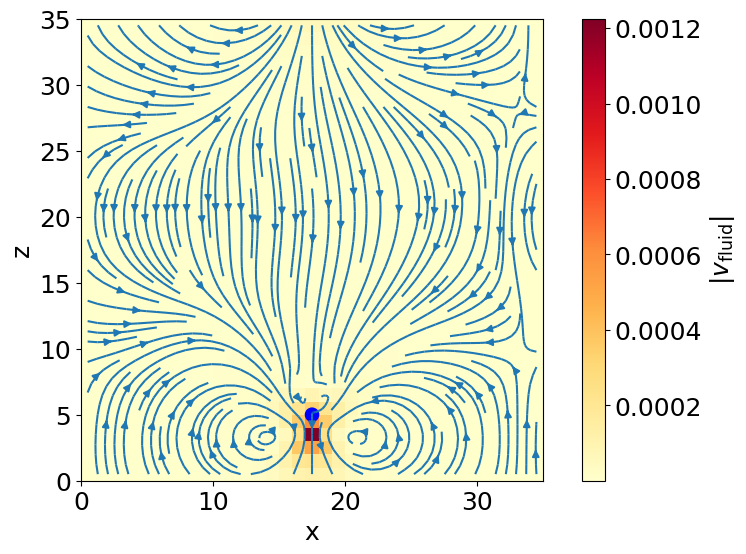

(35, 35, 3)
(35, 35)


In [8]:
# Visualization

vels = np.squeeze(lbf[:, int(system.box_l[1]/2), :].velocity)
vel_abs = np.linalg.norm(vels, axis=2)

lb_shape = lbf.shape
xs, zs = np.meshgrid(np.linspace(0.5, box_l[0] - 0.5, num=lb_shape[0]),
                     np.linspace(0.5, box_l[2] - 0.5, num=lb_shape[2]))

fig_vels, ax_vels = plt.subplots(figsize=(10, 6))
im = plt.pcolormesh(vel_abs.T, cmap='YlOrRd')
vels = np.copy(vels)
ax_vels.streamplot(xs, zs, vels[:, :, 0].T, vels[:, :, 2].T, density=1.5)
circ = plt.Circle(particle.pos_folded[[0, 2]], 0.5, color='blue')
ax_vels.add_patch(circ)
ax_vels.set_aspect('equal')
plt.xlabel('x')
plt.ylabel('z')
cb = plt.colorbar(im, label=r'$|v_{\mathrm{fluid}}|$')
plt.show()
print(np.shape(vels))
print(np.shape(vel_abs))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import tempfile
import base64

# Define the HTML video tag template
VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

# Set ignore 'divide' and 'invalid' errors
# These occur when plotting the flowfield containing a zero velocity
np.seterr(divide='ignore', invalid='ignore')

# Function to convert animation to HTML
def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with tempfile.NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            with open(f.name, "rb") as g:
                video = g.read()
        anim._encoded_video = base64.b64encode(video).decode('ascii')
        plt.close(anim._fig)
    return VIDEO_TAG.format(anim._encoded_video)

# Assign the HTML conversion function to Animation class
animation.Animation._repr_html_ = anim_to_html


# Define the draw_frame function
def draw_frame(t):
    
    # Visualization code for plotting velocity field and other elements
    vels = np.squeeze(lbf[:, int(system.box_l[1]/2), :].velocity)
    vel_abs = np.linalg.norm(vels, axis=2)

    lb_shape = lbf.shape
    xs, zs = np.meshgrid(np.linspace(0.5, box_l[0] - 0.5, num=lb_shape[0]),
                     np.linspace(0.5, box_l[2] - 0.5, num=lb_shape[2]))

    fig_vels, ax_vels = plt.subplots(figsize=(10, 6))
    im = plt.pcolormesh(vel_abs.T, cmap='YlOrRd')
    vels = np.copy(vels)
    ax_vels.streamplot(xs, zs, vels[:, :, 0].T, vels[:, :, 2].T, density=1.5)
    circ = plt.Circle(particle.pos_folded[[0, 2]], 0.5, color='blue')
    ax_vels.add_patch(circ)
    ax_vels.set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(f'Frame {t}')  # Add frame number to title
    cb = plt.colorbar(im, label=r'$|v_{\mathrm{fluid}}|$')
        
def draw_frame(t):
    # manually remove Quivers from ax2
    for artist in ax2.get_children():
        if isinstance(artist, matplotlib.quiver.Quiver):
            artist.remove()

    # draw new quivers
    lb_ff = plot_lb_vel(ax2, X, Y, data_flowfield_t, t, quiver_scale)

    # draw particles
    ld_particles.set_data(data_ld[t, :, 0], data_ld[t, :, 1])
    lb_particles.set_data(data_lb[t, :, 0], data_lb[t, :, 1])

    return [ld_particles, lb_particles, lb_ff]
    
# Create the animation
animation.FuncAnimation(fig_vels, draw_frame, frames=HYDRO_N_STEPS, blit=True, interval=100)


In [ ]:
print(80/6)

In [ ]:
fig = plt.figure(figsize=(2 * 5, 5 / box_width * box_height))
gs = fig.add_gridspec(1, 2, wspace=0.1)
ax1 = plt.subplot(gs[0])

ax1.set_title("Time advance")
ax1.set_xlim((0, box_width))
ax1.set_ylim((0, box_height))

# draw walls
for ax in [ax1]:
    ax.hlines((1, box_height-1), 0, box_width, color="gray")

# create meshgrid for quiver plot
xs = np.array([x for x in range(n_width)]) * spacing
ys = np.array([y for y in range(1, n_height-1)]) * spacing
X, Y = np.meshgrid(xs, ys)

# create a transposed flow field for quiver plot
data_flowfield_t = np.transpose(data_flowfield, axes=(0, 2, 1, 3))

# set quiver scale (fraction of the highest velocity in the XY plane)
lb_vel_max = np.sum(np.square(data_flowfield), axis=-1)
quiver_scale = np.sqrt(np.max(lb_vel_max))

def plot_lb_vel(ax, X, Y, flowfield, t, scale):
    return ax.quiver(X, Y,
                     flowfield[t, :, :, 0],
                     flowfield[t, :, :, 1],
                     scale_units="xy", scale=scale)

# initialize plot objects
lb_ff = plot_lb_vel(ax1, X, Y, data_flowfield_t, 0, quiver_scale)
lb_particles, = ax1.plot([], [], 'o')

def draw_frame(t):
    # manually remove Quivers from ax2
    for artist in ax1.get_children():
        if isinstance(artist, matplotlib.quiver.Quiver):
            artist.remove()

    # draw new quivers
    lb_ff = plot_lb_vel(ax1, X, Y, data_flowfield_t, t, quiver_scale)

    # draw particles
    lb_particles.set_data(data_lb[t, :, 0], data_lb[t, :, 1])

    return [lb_particles, lb_ff]

animation.FuncAnimation(fig, draw_frame, frames=sampling_steps, blit=True, interval=0, repeat=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Example data (replace with your own data)
num_frames = 100
data = np.random.rand(num_frames, 10)  # Random data for demonstration

# Function to update the figure for each frame
def update(frame):
    plt.clf()  # Clear previous frame
    plt.plot(data[frame])  # Plot new frame
    plt.title(f'Frame {frame}')  # Add frame number to title

# Create a new figure
fig, ax = plt.subplots()

# Create the animation object
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=False)

# Display the animation directly in the output
ani

